In [2]:
import numpy as np
import pandas as pd

In [50]:
caption_all_final = caption_all.copy()
caption_neg_final = caption_neg.copy()

In [61]:
vqa_all_final = caption_all.copy()
vqa_neg_final = caption_neg.copy()

In [45]:
instruct_all_final = caption_all.copy()
instruct_neg_final = caption_neg.copy()

In [68]:
print(instruct_all_final.shape)
instruct_all_final.head(2)

(9005, 4)


,image_id,question,answer,target_words
0,2316743.jpg,Can you see a bench at the top of the image?,"No, the bench is in the bottom of the image.","[{'word': 'image', 'class': 'object', 'bbox': ..."
1,150505.jpg,Are there lamps situated close to the couch wi...,"No, there is a chair near the couch.","[{'word': 'chair', 'class': 'object', 'bbox': ..."


In [251]:
instruct_neg_final.shape

(11817, 4)

In [70]:
print(instruct_neg_final.shape)
instruct_neg_final.head(2)

(11817, 4)


,question,image_id,answer,target_words
0,Do you see a bottle on a desk?,2324272,"Yes, the bottle is on a desk.","[{'word': 'desk', 'class': 'object', 'bbox': [..."
1,Is the towel positioned on the oven?,2403906,"Yes, the towel is on the oven.","[{'word': 'oven', 'class': 'object', 'bbox': [..."


In [88]:
total_df = pd.concat([caption_all_final, caption_neg_final, vqa_all_final, vqa_neg_final, instruct_all_final, instruct_neg_final])

In [89]:
total_df.head(2)

,image_id,question,answer,target_words
0,2415095.jpg,What do you think is going on in this snapshot?,This image consists of a bird eating a food wh...,"[{'word': 'bird', 'class': 'object', 'bbox': [..."
1,2381594.jpg,What do you see happening in this image?,In this image I can see train. The train is in...,"[{'word': 'side', 'class': 'decision_token', '..."


In [90]:
total_df.shape

(66034, 4)

In [92]:
def fill_empty_bboxes(data):

    if isinstance(data, str):
        data = eval(data)
    
    default_bbox = [{'h': 0, 'w': 0, 'y': 0, 'x': 0}]
    
    for item in data:
        if 'bbox' in item and (not item['bbox'] or len(item['bbox']) == 0):
            item['bbox'] = default_bbox.copy()
    return data

In [93]:
total_df["target_words"] = total_df["target_words"].apply(lambda x: fill_empty_bboxes(x))

In [94]:
def convert_bboxes_hwxy_to_xyxy(data, image_width, image_height, clip=True):

    def clamp(v, low, high):
        return max(low, min(high, v))

    out = []

    for item in data:
        new_item = {
            "word": item.get("word"),
            "class": item.get("class"),
            "bbox": []
        }

        for box in item.get("bbox", []):
            x = int(box.get("x", 0))
            y = int(box.get("y", 0))
            w = int(box.get("w", 0))
            h = int(box.get("h", 0))

            xmin = x
            ymin = y
            xmax = x + w
            ymax = y + h

            if clip:
                xmin = clamp(xmin, 0, image_width)
                xmax = clamp(xmax, 0, image_width)
                ymin = clamp(ymin, 0, image_height)
                ymax = clamp(ymax, 0, image_height)

            new_item["bbox"].append(
                {
                    "xmin": xmin,
                    "ymin": ymin,
                    "xmax": xmax,
                    "ymax": ymax,
                }
            )

        out.append(new_item)

    return out

In [95]:
total_df["image_id"] = total_df["image_id"].apply(lambda x: x.strip(".jpg") if isinstance(x, str) else str(x))

In [96]:
total_df.head(2)

,image_id,question,answer,target_words
0,2415095,What do you think is going on in this snapshot?,This image consists of a bird eating a food wh...,"[{'word': 'bird', 'class': 'object', 'bbox': [..."
1,2381594,What do you see happening in this image?,In this image I can see train. The train is in...,"[{'word': 'side', 'class': 'decision_token', '..."


In [97]:
from PIL import Image
from tqdm import tqdm

new_bboxes_list = []
for idx, row in tqdm(total_df.iterrows(), total=total_df.shape[0]):
    image_path = "/Data2/Arun-UAV/NLP/vision_halu/visual_genome/VG_100K/" + row["image_id"] + ".jpg"
    img_shape = Image.open(image_path).size
    image_width = img_shape[0]
    image_height = img_shape[1]
    target_words = row['target_words']
    converted_bboxes = convert_bboxes_hwxy_to_xyxy(target_words, image_width, image_height, clip=True)
    new_bboxes_list.append(converted_bboxes)

100%|██████████| 66034/66034 [00:10<00:00, 6558.62it/s]


In [98]:

total_df["target_words"] = new_bboxes_list

In [99]:
total_df.to_csv("/Data2/Arun-UAV/NLP/vision_halu/evidence_head_train_datasets/holoc/total_holoc_evidence_head_train_data_60k.csv", index=False)

In [54]:
caption_all = pd.read_csv("/Data2/Arun-UAV/NLP/vision_halu/evidence_head_train_datasets/holoc/vqa/holoc_sampled_10k_bb_annot.csv")
caption_neg = pd.read_csv("/Data2/Arun-UAV/NLP/vision_halu/evidence_head_train_datasets/holoc/vqa/obj_neg.csv")
# caption_neg = caption_neg[caption_neg["bb_info"] .apply(lambda x: len(eval(x)) <= 1)]
caption_neg["bb_info"] = caption_neg["bb_info"].apply(lambda data: eval(data))
caption_neg["bb_info"] = caption_neg["bb_info"].apply(lambda data: [{"word": data["word"], 'class': 'object', "bbox": [{"h" : 0, "w": 0, "x": 0, "y": 0}]}])
caption_neg.columns = ["question", "image_id","answer", "target_words"]
caption_all.columns =  ["image_id", "question", "answer", "target_words"]

In [55]:
caption_neg.head(2)

,question,image_id,answer,target_words
0,"The question ""On what is that label?"" can be a...",2328443,bicycle,"[{'word': 'bicycle', 'class': 'object', 'bbox'..."
1,What is the answer to the following question? ...,2354185,motorcycle helmet,"[{'word': 'motorcycle helmet', 'class': 'objec..."


In [57]:
caption_neg.shape

(11929, 4)

In [59]:
caption_all.head(2)

,image_id,question,answer,target_words
0,2381171.jpg,What is the color of the surfboard in the water?,blue,"[{'word': 'blue', 'class': 'attribute', 'bbox'..."
1,2347211.jpg,Q: What color is the mane? A:,white,"[{'word': 'white', 'class': 'attribute', 'bbox..."


In [60]:
caption_all.shape

(9950, 4)

# bounding box scaling

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import random

def plot_bounding_boxes_xyxy(image_path, boxes):
    """
    Plots bounding boxes on an image using matplotlib.

    Args:
        image_path (str): Path to the image file.
        boxes (list[dict]): List of bounding boxes in dict format.
                            Each box should have keys: {'xmin', 'ymin', 'xmax', 'ymax'}
    """
    # Load the image
    image = Image.open(image_path).convert("RGB")
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    # Get a set of distinct colors
    colors = list(plt.cm.tab10.colors)
    random.shuffle(colors)

    # Draw each bounding box
    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box['xmin'], box['ymin'], box['xmax'], box['ymax']
        color = colors[i % len(colors)]
        
        width = xmax - xmin
        height = ymax - ymin

        rect = patches.Rectangle((xmin, ymin), width, height,
                                 linewidth=2,
                                 edgecolor=color,
                                 facecolor='none')
        ax.add_patch(rect)
        
        # Label each box
        ax.text(xmin, ymin - 5, f"Box {i+1}", color=color,
                fontsize=10, fontweight="bold", backgroundcolor='white')

    plt.axis('off')
    plt.show()

In [134]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

def _to_pil(img, image_processor=None):
    """Convert PIL / numpy / processor-normalized tensor -> PIL.Image (uint8)."""
    if isinstance(img, Image.Image):
        return img

    if isinstance(img, torch.Tensor):
        # Accept (B,3,H,W) or (3,H,W). If normalized, unnormalize via processor.
        if img.ndim == 4:
            img = img[0]
        assert img.ndim == 3 and img.shape[0] in (1,3), "Expect (C,H,W) tensor."
        x = img.clone()

        # If in [-~3, ~3] range (typical normalized), try unnormalize
        if image_processor is not None and (x.max() > 1.5 or x.min() < -0.5):
            mean = torch.tensor(
                getattr(image_processor, "image_mean", [0.5, 0.5, 0.5]),
                dtype=x.dtype, device=x.device
            )[:, None, None]
            std = torch.tensor(
                getattr(image_processor, "image_std", [0.5, 0.5, 0.5]),
                dtype=x.dtype, device=x.device
            )[:, None, None]
            x = x * std + mean

        # Move to CPU, [0,1], CHW->HWC uint8
        x = x.clamp(0,1).permute(1,2,0).detach().cpu().numpy()
        arr = (x * 255).round().astype(np.uint8)
        return Image.fromarray(arr)

    if isinstance(img, np.ndarray):
        if img.dtype != np.uint8:
            arr = np.clip(img, 0, 1)
            arr = (arr * 255).round().astype(np.uint8)
        else:
            arr = img
        if arr.ndim == 3 and arr.shape[2] == 3:
            return Image.fromarray(arr)
        raise ValueError("NumPy image must be HxWx3.")
    raise TypeError("Unsupported image type. Use PIL.Image, torch.Tensor, or np.ndarray.")

def _coerce_boxes(boxes):
    norm = []
    for b in boxes:
        if isinstance(b, dict):
            xmin, ymin, xmax, ymax = b["xmin"], b["ymin"], b["xmax"], b["ymax"]
        else:
            xmin, ymin, xmax, ymax = b  # (xmin,ymin,xmax,ymax)
        norm.append((float(xmin), float(ymin), float(xmax), float(ymax)))
    return norm

def plot_boxes_on_image(image_or_tensor, boxes, image_processor=None, labels=None,
                        linewidth=2, color="red"):
    """
    Draw bounding boxes with optional color or per-box color list.
    """
    pil = _to_pil(image_or_tensor, image_processor=image_processor)
    W, H = pil.size
    print(f"Image size: {W}x{H}")
    boxes = _coerce_boxes(boxes)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(pil)
    ax.axis("off")

    # Default color
    if color is None:
        color = "red"

    for i, (xmin, ymin, xmax, ymax) in enumerate(boxes):
        xi, yi, xa, ya = map(int, [xmin, ymin, xmax, ymax])
        left, top = min(xi, xa), min(yi, ya)
        w, h = abs(xa - xi), abs(ya - yi)

        # Allow color to be a single string or list of colors per box
        this_color = color[i] if isinstance(color, (list, tuple)) and len(color) == len(boxes) else color

        rect = Rectangle((left, top), w, h,
                         linewidth=linewidth,
                         edgecolor=this_color,
                         facecolor='none')   # <--- no fill, colored edge
        ax.add_patch(rect)

        if labels is not None:
            ax.text(left, max(10, top - 4), str(labels[i]),
                    fontsize=9,
                    color=this_color,
                    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", pad=1.5))

    plt.tight_layout()
    return fig, ax

In [135]:
from typing import List, Dict, Tuple, Optional
from PIL import Image
import math

def map_bboxes_to_llava336(
    image_path: str,
    boxes: List[Dict[str, int]],
    target_shortest: int = 336,
    crop_size: Tuple[int, int] = (336, 336),
    do_center_crop: bool = True,
    drop_empty: bool = True,
) -> Tuple[List[Dict[str, int]], Dict[str, int]]:
    """
    Map (xmin, ymin, xmax, ymax) boxes from original image coords to the
    LLaVA/CLIP-processed 336x336 space.
    
    Args:
        image_path: path to original image.
        boxes: list of dicts like {"xmin": int, "ymin": int, "xmax": int, "ymax": int}
        target_shortest: shortest edge after resize (typically 336 for LLaVA-1.5 @336).
        crop_size: final crop size (h, w). Typically (336, 336).
        do_center_crop: True to mirror CLIP’s center crop; False if your pipeline skipped crop.
        drop_empty: if True, discard boxes that have no overlap after crop. If False, returns
                    clipped zero/negative-area boxes (still clipped to [0, crop_dim]).
    
    Returns:
        (new_boxes, params)
        new_boxes: list of dicts in same structure with integer coords within [0, crop_dim].
        params: dict with scale and offsets used: 
                {"scale": s, "resized_h": Hs, "resized_w": Ws, "offset_x": ox, "offset_y": oy,
                 "out_h": out_h, "out_w": out_w}
    """
    # 1) Read dims
    with Image.open(image_path) as im:
        W, H = im.size  # PIL: (width, height)
    
    # 2) Resize to set shortest edge = target_shortest
    shortest = min(H, W)
    s = target_shortest / float(shortest)
    Hs = int(round(H * s))
    Ws = int(round(W * s))
    
    # 3) Center crop params (if enabled)
    out_h, out_w = crop_size
    if do_center_crop:
        ox = max(0, (Ws - out_w) // 2)  # crop left in resized space
        oy = max(0, (Hs - out_h) // 2)  # crop top  in resized space
    else:
        # No crop → output is just the resized image
        ox = 0
        oy = 0
        out_h, out_w = Hs, Ws
    
    def _transform_one(b):
        # scale with safe rounding (expand slightly after scale)
        xmin_s = math.floor(b["xmin"] * s)
        ymin_s = math.floor(b["ymin"] * s)
        xmax_s = math.ceil(b["xmax"] * s)
        ymax_s = math.ceil(b["ymax"] * s)
        
        # shift by crop offsets
        xmin_c = xmin_s - ox
        ymin_c = ymin_s - oy
        xmax_c = xmax_s - ox
        ymax_c = ymax_s - oy
        
        # clip to output frame
        xmin_c = max(0, min(out_w, xmin_c))
        ymin_c = max(0, min(out_h, ymin_c))
        xmax_c = max(0, min(out_w, xmax_c))
        ymax_c = max(0, min(out_h, ymax_c))
        
        return {"xmin": int(xmin_c), "ymin": int(ymin_c), "xmax": int(xmax_c), "ymax": int(ymax_c)}
    
    mapped = []
    for b in boxes:
        nb = _transform_one(b)
        if drop_empty:
            if nb["xmax"] > nb["xmin"] and nb["ymax"] > nb["ymin"]:
                mapped.append(nb)
        else:
            mapped.append(nb)
    
    params = {
        "scale": s,
        "resized_h": Hs,
        "resized_w": Ws,
        "offset_x": ox,
        "offset_y": oy,
        "out_h": out_h,
        "out_w": out_w,
    }
    return mapped, params

In [316]:
def apply_downscale_bb(image_path, bb_info):
    bb_info = eval(bb_info)
    ds_bb_info = []
    for i in bb_info:
        new_boxes, _ = map_bboxes_to_llava336(
            image_path=image_path,
            boxes = i["bbox"],
            target_shortest=336,
            crop_size=(336, 336),
            do_center_crop=True,
            drop_empty=False
        )
        i["bbox"] = new_boxes
        ds_bb_info.append(i)
    return ds_bb_info

In [248]:
from tqdm import tqdm
all_ds_bb_info = []
for inx, row in tqdm(total_holoc_df.iterrows(), total=total_holoc_df.shape[0]):
    image_path = "/Data2/Arun-UAV/NLP/vision_halu/visual_genome/VG_100K/" + row["image_id"] + ".jpg"
    ds_bb_info = apply_downscale_bb(image_path, row["target_words"])
    all_ds_bb_info.append(ds_bb_info)

100%|██████████| 65137/65137 [00:26<00:00, 2459.04it/s]


In [252]:
total_holoc_df["downscale_target_words_bb_info"] = all_ds_bb_info

In [254]:
total_holoc_df.tail(2)

,image_id,question,answer,target_words,downscale_target_words_bb_info
39782,2390301,What is the answer to the following question? ...,collar,"[{'word': 'collar', 'class': 'object', 'bbox':...","[{'word': 'collar', 'class': 'object', 'bbox':..."
47039,2370994,Are the tiles white in color?,"No, the tiles are red.","[{'word': 'tiles', 'class': 'object', 'bbox': ...","[{'word': 'tiles', 'class': 'object', 'bbox': ..."


In [255]:
from transformers import CLIPVisionModel, CLIPImageProcessor, CLIPVisionConfig
image_processor = CLIPImageProcessor.from_pretrained('openai/clip-vit-large-patch14-336')

/home/user/.conda/envs/shdm/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [149]:
total_holoc_df = pd.read_csv("/Data2/Arun-UAV/NLP/vision_halu/evidence_head_train_datasets/holoc/total_holoc_evidence_head_train_data_60k.csv")

In [150]:
total_holoc_df["image_id"] = total_holoc_df["image_id"].apply(lambda x: str(int(x)))

In [154]:
total_holoc_df = total_holoc_df.sample(frac=1)

In [194]:
total_holoc_df = total_holoc_df[total_holoc_df["target_words"].apply(lambda x: len(eval(x))!=0)]

In [256]:
total_holoc_df.head(2)

,image_id,question,answer,target_words,downscale_target_words_bb_info
38859,2410010,Question: Where is the pot?,on ground,"[{'word': 'on ground', 'class': 'object', 'bbo...","[{'word': 'on ground', 'class': 'object', 'bbo..."
60190,2401504,Is there a boat visible in the ocean within th...,"Yes, there is a boat in the ocean.","[{'word': 'boat', 'class': 'object', 'bbox': [...","[{'word': 'boat', 'class': 'object', 'bbox': [..."


In [281]:
i = 11218
image_path = "/Data2/Arun-UAV/NLP/vision_halu/visual_genome/VG_100K/" + total_holoc_df["image_id"].iloc[i] + ".jpg"
print(len(eval(total_holoc_df["target_words"].iloc[i])))
print(len(total_holoc_df["downscale_target_words_bb_info"].iloc[i]))
print(total_holoc_df["question"].iloc[i])
print(total_holoc_df["answer"].iloc[i])

3
3
Is the bus white in color?
No, the bus is black.


In [294]:
j = 2
eval(total_holoc_df["target_words"].iloc[i])[j]

{'word': 'black',
 'class': 'attribute',
 'bbox': [{'xmin': 57, 'ymin': 100, 'xmax': 351, 'ymax': 258}]}

In [290]:
j = 2
total_holoc_df["downscale_target_words_bb_info"].iloc[i][j]

{'word': 'black',
 'class': 'attribute',
 'bbox': [{'xmin': 0, 'ymin': 100, 'xmax': 271, 'ymax': 261}]}

In [291]:
from PIL import Image

image = Image.open(image_path).convert("RGB")
image_tensor = image_processor([image], return_tensors="pt")["pixel_values"]

Image size: 336x336


(<Figure size 600x600 with 1 Axes>, <Axes: >)

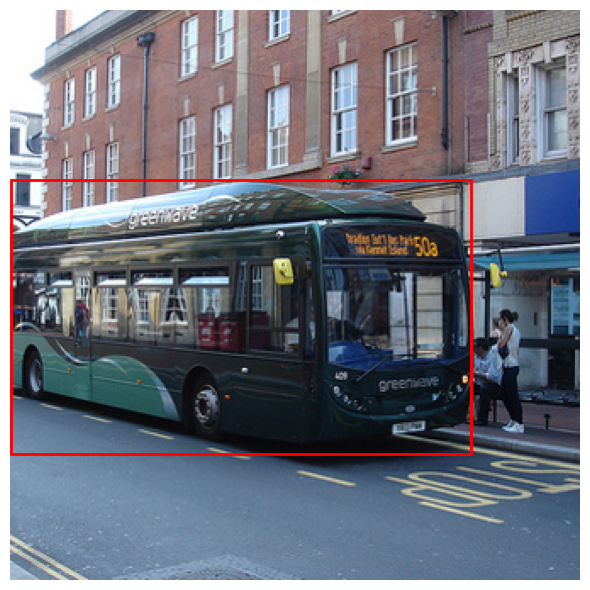

In [292]:
plot_boxes_on_image(image_tensor, total_holoc_df["downscale_target_words_bb_info"].iloc[i][j]["bbox"], image_processor=image_processor, labels=None,
                        linewidth=2, color="red")

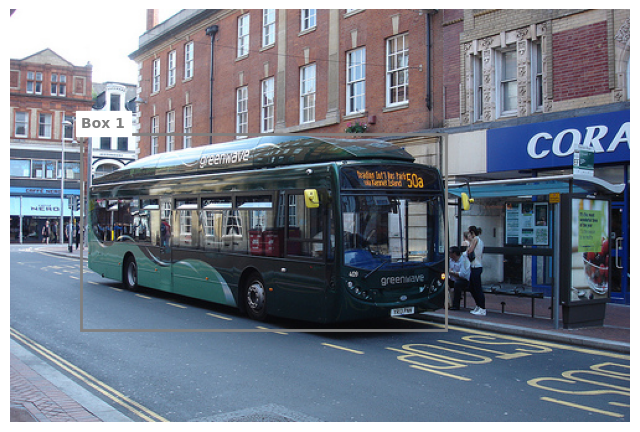

In [293]:
plot_bounding_boxes_xyxy(image_path, eval(total_holoc_df["target_words"].iloc[i])[j]["bbox"])

In [295]:
total_holoc_df.head(2)

,image_id,question,answer,target_words,downscale_target_words_bb_info
38859,2410010,Question: Where is the pot?,on ground,"[{'word': 'on ground', 'class': 'object', 'bbo...","[{'word': 'on ground', 'class': 'object', 'bbo..."
60190,2401504,Is there a boat visible in the ocean within th...,"Yes, there is a boat in the ocean.","[{'word': 'boat', 'class': 'object', 'bbox': [...","[{'word': 'boat', 'class': 'object', 'bbox': [..."


In [309]:
target_df = pd.read_csv("/Data2/Arun-UAV/NLP/vision_halu/evidence_head_train_datasets/holoc/downscaled_total_holoc_evidence_head_train_data_60k.csv")

In [310]:
target_df.head(2)

,image_id,question,answer,target_words,downscale_target_words_bb_info,image_path
0,2410010,Question: Where is the pot?,on ground,"[{'word': 'on ground', 'class': 'object', 'bbo...","[{'word': 'on ground', 'class': 'object', 'bbo...",/Data2/Arun-UAV/NLP/vision_halu/visual_genome/...
1,2401504,Is there a boat visible in the ocean within th...,"Yes, there is a boat in the ocean.","[{'word': 'boat', 'class': 'object', 'bbox': [...","[{'word': 'boat', 'class': 'object', 'bbox': [...",/Data2/Arun-UAV/NLP/vision_halu/visual_genome/...


In [306]:
target_df["image_path"] = target_df["image_id"].apply(lambda x: "/Data2/Arun-UAV/NLP/vision_halu/visual_genome/VG_100K/" + str(int(x)) + ".jpg")

In [308]:
target_df.to_csv("/Data2/Arun-UAV/NLP/vision_halu/evidence_head_train_datasets/holoc/downscaled_total_holoc_evidence_head_train_data_60k.csv", index=False)

In [315]:
target_df["image_path"].iloc[1]

'/Data2/Arun-UAV/NLP/vision_halu/visual_genome/VG_100K/2401504.jpg'